# H-R Diagram

This notebook shows how to go from the pipeline-reduced images of a star cluster to an H-R diagram.

The data were taken during the fall 2020 semester using the STL-11000M CCD and the 0.7-m telescope at Siena's Breyo Observatory.

We took images in V and R, even though historically B and V are used more frequently for an HR diagram.

Found isochrones - see below

# Effective Temperature and V-R color

most historical HR diagrams are measured in the B and V filters, and the horizontal axis of the HR diagram is in terms of B-V.

We measured the star colors using the V and R filters.  

We can related V-R color to effective temperature using the table in:

http://articles.adsabs.harvard.edu//full/1969tons.conf...27M/0000029.000.html


http://web.mit.edu/12.409/www/12.401-m44final.html
gives from a fit to MS stars
(B-V) = -0.104(V-R)^2 + 1.355(V-R) - 0.080 

### This is the best option - get isochrones in V vs V-R space!
can get isochrones here
http://www.astro.ex.ac.uk/people/timn/isochrones/


In [25]:
import os
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import scoreatpercentile
import glob

from reproject import reproject_interp
from astropy.wcs import WCS
from astropy.io import fits
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

from photutils import CircularAperture
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS


# Define Functions

In [64]:
def display_image(imagename,cmap='Greys',rawdata=False,percent=90,wcs=False):
    
    if not(rawdata):
        d,h = fits.getdata(imagename,header=True)
    else:
        d = imagename
        h = imagename.header
    if wcs:
        plt.subplot(1,1,1,projection = WCS(h))
    norm = simple_norm(d,'sqrt',percent=percent)
    plt.imshow(d,norm=norm,cmap=cmap)
    plt.colorbar(fraction=0.046, pad=0.04)

In [192]:
def plot_isochrones(distmod=0):
    ''' plot isochrones that were downloaded from http://www.astro.ex.ac.uk/people/timn/isochrones/'''
    ## read in isochrone files
    isochrone_dir = '/home/rfinn/siena/courses/ASTR380/HR/isochrones/'
    cfiles = glob.glob(isochrone_dir+'*.iso')
    cfiles = np.sort(cfiles)
    #cfiles = ['isochrones/V_V-R_07.000.iso','isochrones/V_V-R_08.000.iso']#,'isochrones/V_V-R_09.000.iso']
    #labels=['log10(age)=7','log10(age)=8']
    for i in range(len(cfiles)):
        t = Table.read(cfiles[i],format='ascii',header_start=4)
        age = os.path.basename(cfiles[i]).split('V_V-R_')[1].split('.iso')[0]
        mylabel = 'log10(age) = {:.1f}'.format(float(age))
        print(mylabel)
        plt.plot(t['V-R'],t['V']+distmod,label=mylabel)
        ## plot isochrones

# Define Data Directory

In [11]:
datadir = '/home/rfinn/siena/observatory/reduced/2020-10-14/'

# Align Images

In [33]:
vfiles = glob.glob(datadir+'c*M39*v*.fits')
rfiles = glob.glob(datadir+'c*M39*r*.fits')

In [14]:
os.chdir('/home/rfinn/siena/courses/ASTR380/HR/')

In [24]:
refimage='/home/rfinn/siena/observatory/reduced/2020-10-14/cazfbp-M39-0001v.fits'
hdu_ref = fits.open(refimage)[0]
for i in np.arange(len(rfiles)):
  hdu_next = fits.open(rfiles[i])[0]
  reproject_image, footprint = reproject_interp(hdu_next, hdu_ref.header)
  # remove path and save the shifted image to the current directory
  outfile = '{}-shifted.fits'.format(os.path.basename(rfiles[i]).split('.fits')[0])
  fits.writeto(outfile,reproject_image,hdu_ref.header,overwrite=True)

In [ ]:
refimage='/home/rfinn/siena/observatory/reduced/2020-10-14/cazfbp-M39-0001v.fits'
hdu_ref = fits.open(refimage)[0]
for i in np.arange(len(vfiles)):
  hdu_next = fits.open(vfiles[i])[0]
  reproject_image, footprint = reproject_interp(hdu_next, hdu_ref.header)
  # remove path and save the shifted image to the current directory
  outfile = '{}-shifted.fits'.format(os.path.basename(vfiles[i]).split('.fits')[0])
  fits.writeto(outfile,reproject_image,hdu_ref.header,overwrite=True)

### Repeat for M15


In [34]:
# get list of images
vfiles_M15 = glob.glob(datadir+'c*M15*v*.fits')
rfiles_M15 = glob.glob(datadir+'c*M15*r*.fits')

In [26]:
# combine v and r files into one list
allfiles = vfiles_M15 + rfiles_M15
# define reference image - all images will be aligned to this one
refimage=vfiles_M15[0]#'/home/rfinn/siena/observatory/reduced/2020-10-14/cazfbp-M15-0001v.fits'
hdu_ref = fits.open(refimage)[0]
for i in np.arange(len(allfiles)):
  hdu_next = fits.open(allfiles[i])[0]
  reproject_image, footprint = reproject_interp(hdu_next, hdu_ref.header)
  # remove path and save the shifted image to the current directory
  outfile = '{}-shifted.fits'.format(os.path.basename(allfiles[i]).split('.fits')[0])
  fits.writeto(outfile,reproject_image,hdu_ref.header,overwrite=True)


## Combine the shifted r and v images

In [30]:
from ccdproc import combine


In [46]:
m39shifted_v = glob.glob('*M39*v-shifted.fits')
m39shifted_r = glob.glob('*M39*r-shifted.fits')
m15shifted_v = glob.glob('*M15*v-shifted.fits')
m15shifted_r = glob.glob('*M15*r-shifted.fits')

In [109]:
m39ave_r = combine(m39shifted_r,method='average',sigma_clip=True)

m39ave_v = combine(m39shifted_v,method='average',sigma_clip=True)
m15ave_r = combine(m15shifted_r,method='average',sigma_clip=True)
m15ave_v = combine(m15shifted_v,method='average',sigma_clip=True)

/home/rfinn/anaconda3/lib/python3.7/site-packages/ccdproc/combiner.py:300: RuntimeWarning: invalid value encountered in less
  mask = (self.data_arr - baseline < -low_thresh * dev)
/home/rfinn/anaconda3/lib/python3.7/site-packages/ccdproc/combiner.py:303: RuntimeWarning: invalid value encountered in greater
  mask = (self.data_arr - baseline > high_thresh * dev)


In [110]:
d,h = fits.getdata(m39shifted_v[0],header=True)
m39ave_r.header = h
m39ave_v.header = h

d,h = fits.getdata(m15shifted_v[0],header=True)
m15ave_r.header = h
m15ave_v.header = h

In [71]:
outfile = 'test.fits'
fits.writeto(outfile,m39ave_r.data,header=m39ave_r.header,overwrite=True)

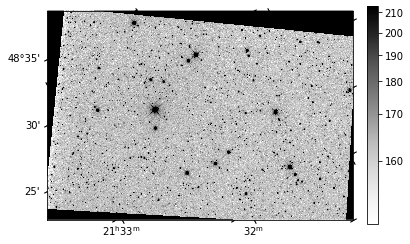

In [135]:
display_image(m39ave_r,rawdata=True,percent=98,wcs=True)

# Find stars and measure their brightness - M39

In [174]:
snr_threshold = 5
rimage = m39ave_r
vimage = m39ave_v
# read in first image
data_r, header_r = rimage.data, rimage.header
# estimate background counts in image
mean, median, std = sigma_clipped_stats(data_r, sigma=3.0)
# set up daofind, with info about our image fwhm and the detection threshold
daofind = DAOStarFinder(fwhm=2.7, threshold=snr_threshold*std)
# detect sources, using the image - median (subtract sky level from image)
sources_r = daofind(data_r - median)
w = WCS(header_r)
ra_r,dec_r = w.wcs_pix2world(sources_r['xcentroid'],sources_r['ycentroid'],0)

# repeat for v-band image
data_v, header_v = vimage.data, vimage.header
# estimate background counts in image
mean, median, std = sigma_clipped_stats(data_v, sigma=3.0)
# set up daofind, with info about our image fwhm and the detection threshold
daofind = DAOStarFinder(fwhm=2.7, threshold=snr_threshold*std)
# detect sources, using the image - median (subtract sky level from image)
sources_v = daofind(data_v - median)
w = WCS(header_v)
ra_v,dec_v = w.wcs_pix2world(sources_v['xcentroid'],sources_v['ycentroid'],0)


# Match R and V catalogs

In [141]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

In [175]:
r_catalog = SkyCoord(ra=ra_r*u.degree, dec=dec_r*u.degree)
v_catalog = SkyCoord(ra=ra_v*u.degree, dec=dec_v*u.degree)
idx, d2d, d3d = r_catalog.match_to_catalog_sky(v_catalog)

In [176]:
# only keep objects with matching coordinates within 5 arcsec
matchflag = d2d < 2./3600*u.deg
#rmag = sources_r['mag'][matchflag]
#vmag = sources_v['mag'][idx[matchflag]]
vmag_m39 = 17. + (sources_v['mag'])[idx[matchflag]]
rmag_m39 = 17. + (sources_r['mag'])[matchflag]

# Plot V vs V-R

log10(age) = 7.0
log10(age) = 8.0
log10(age) = 9.0
log10(age) = 10.0


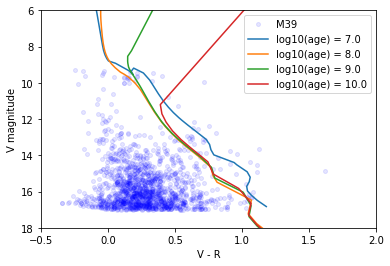

In [200]:
plt.figure()
plt.plot(vmag_m39-rmag_m39,vmag_m39,'bo',markersize=4,alpha=.1,label='M39')
plt.xlim(-.5,2)
plt.ylabel('V magnitude')
plt.xlabel('V - R')

distmod=7
plot_isochrones(distmod)
plt.legend()
plt.axis([-.5,2,6,18])
plt.gca().invert_yaxis()

# Repeat for M15

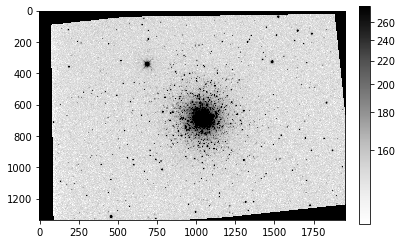

In [111]:
display_image(m15ave_r,rawdata=True,percent=98)

In [187]:
rimage = m15ave_r
vimage = m15ave_v
snr_threshold = 10
# read in first image
data_r, header_r = rimage.data, rimage.header
# estimate background counts in image
mean, median, std = sigma_clipped_stats(data_r, sigma=3.0)
# set up daofind, with info about our image fwhm and the detection threshold
daofind = DAOStarFinder(fwhm=2.7, threshold=snr_threshold*std)
# detect sources, using the image - median (subtract sky level from image)
sources_r = daofind(data_r - median)
w = WCS(header_r)
ra_r,dec_r = w.wcs_pix2world(sources_r['xcentroid'],sources_r['ycentroid'],0)

# repeat for v-band image
data_v, header_v = vimage.data, vimage.header
# estimate background counts in image
mean, median, std = sigma_clipped_stats(data_v, sigma=3.0)
# set up daofind, with info about our image fwhm and the detection threshold
daofind = DAOStarFinder(fwhm=2.7, threshold=snr_threshold*std)
# detect sources, using the image - median (subtract sky level from image)
sources_v = daofind(data_v - median)
w = WCS(header_v)
ra_v,dec_v = w.wcs_pix2world(sources_v['xcentroid'],sources_v['ycentroid'],0)

# match coordinates
r_catalog = SkyCoord(ra=ra_r*u.degree, dec=dec_r*u.degree)
v_catalog = SkyCoord(ra=ra_v*u.degree, dec=dec_v*u.degree)
idx, d2d, d3d = r_catalog.match_to_catalog_sky(v_catalog)
# only keep objects with matching coordinates within 5 arcsec
matchflag = d2d < 5./3600*u.deg
vmag_m15 = 17. + (sources_v['mag'])[idx[matchflag]]
rmag_m15 = 17. + (sources_r['mag'])[matchflag]

log10(age) = 7.0
log10(age) = 8.0
log10(age) = 9.0
log10(age) = 10.0


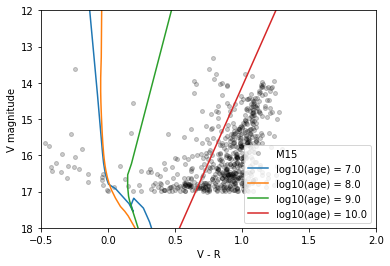

In [194]:
plt.figure()
plt.plot(vmag_m15-rmag_m15,vmag_m15,'ko',markersize=4,alpha=.2,label='M15')
plt.xlim(-.5,2)
plt.ylabel('V magnitude')
plt.xlabel('V - R')

distmod=15
plot_isochrones(distmod)
plt.legend()
plt.axis([-.5,2,12,18])
plt.gca().invert_yaxis()

# To Finish up

* recreate code in your notebook
* estimate your best value for distance modulus (make sure you know what this is)
* estimate your best value for age
* compare with known values
* compare HR diagram for M39 and M15 - what can we learn?